In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import mubind as mb
import numpy as np
import pandas as pd
import torch
import torch.nn as tnn
import torch.optim as topti
import torch.utils.data as tdata
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score

In [3]:
# Use a GPU if available, as it should be faster.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device: " + str(device))

Using device: cpu


In [4]:
data = pd.read_csv('../data/gata1_remap.tsv.gz', sep=',')
data.columns = ['id', 'loc', 'seq', 'target']
misreads = []
for index, seq in enumerate(data['seq']):
    if seq.replace('A', '').replace('C', '').replace('G', '').replace('T', '') is not '':
        misreads.append(index)
data = data.drop(misreads)
data.index = range(len(data))

# train_10000_dataframe = data.sample(n=10000)
train_1000_dataframe = data.sample(n=1000)
train_100_dataframe = train_1000_dataframe.sample(n=100)
train_10_dataframe = train_100_dataframe.sample(n=10)
train_4_dataframe = train_10_dataframe.sample(n=4)
train_1_dataframe = train_4_dataframe.sample(n=1)

train_1_dataframe.index = range(1)
train_4_dataframe.index = range(4)
train_10_dataframe.index = range(10)
train_100_dataframe.index = range(100)
train_1000_dataframe.index = range(1000)
# train_10000_dataframe.index = range(10000)

# train_data = mb.tl.ChipSeqDataset(data_frame=data)
# train_loader = tdata.DataLoader(dataset=train_data, batch_size=256, shuffle=True)
train_1_data = mb.tl.ChipSeqDataset(data_frame=train_1_dataframe)
train_1_loader = tdata.DataLoader(dataset=train_1_data, batch_size=1, shuffle=False)
train_4_data = mb.tl.ChipSeqDataset(data_frame=train_4_dataframe)
train_4_loader = tdata.DataLoader(dataset=train_4_data, batch_size=4, shuffle=False)
train_10_data = mb.tl.ChipSeqDataset(data_frame=train_10_dataframe)
train_10_loader = tdata.DataLoader(dataset=train_10_data, batch_size=10, shuffle=False)
train_100_data = mb.tl.ChipSeqDataset(data_frame=train_100_dataframe)
train_100_loader = tdata.DataLoader(dataset=train_100_data, batch_size=10, shuffle=True)
test_100_loader = tdata.DataLoader(dataset=train_100_data, batch_size=1, shuffle=False)
train_1000_data = mb.tl.ChipSeqDataset(data_frame=train_1000_dataframe)
train_1000_loader = tdata.DataLoader(dataset=train_1000_data, batch_size=64, shuffle=True)
test_1000_loader = tdata.DataLoader(dataset=train_1000_data, batch_size=1, shuffle=False)
# train_10000_data = mb.tl.ChipSeqDataset(data_frame=train_10000_dataframe)
# train_10000_loader = tdata.DataLoader(dataset=train_10000_data, batch_size=256, shuffle=True)
# test_10000_loader = tdata.DataLoader(dataset=train_10000_data, batch_size=1, shuffle=False)

In [5]:
# Mono + Dinuc model, combined via weighted sum
net = mb.tl.NetworkDinuc().to(device)
optimiser = topti.Adam(net.parameters(), lr=0.001)
criterion = tnn.BCELoss()
loss_history = []

In [15]:
loss_history += mb.tl.train_network(net, train_1000_loader, device, optimiser, criterion, num_epochs=100)

Epoch:  1, Loss: 0.434
Epoch:  2, Loss: 0.433
Epoch:  3, Loss: 0.436
Epoch:  4, Loss: 0.433
Epoch:  5, Loss: 0.438
Epoch:  6, Loss: 0.437
Epoch:  7, Loss: 0.434
Epoch:  8, Loss: 0.434
Epoch:  9, Loss: 0.437
Epoch: 10, Loss: 0.434
Epoch: 11, Loss: 0.435
Epoch: 12, Loss: 0.435
Epoch: 13, Loss: 0.434
Epoch: 14, Loss: 0.434
Epoch: 15, Loss: 0.435
Epoch: 16, Loss: 0.434
Epoch: 17, Loss: 0.436
Epoch: 18, Loss: 0.434
Epoch: 19, Loss: 0.436
Epoch: 20, Loss: 0.437
Epoch: 21, Loss: 0.439
Epoch: 22, Loss: 0.434
Epoch: 23, Loss: 0.435
Epoch: 24, Loss: 0.432
Epoch: 25, Loss: 0.435
Epoch: 26, Loss: 0.434
Epoch: 27, Loss: 0.433
Epoch: 28, Loss: 0.433
Epoch: 29, Loss: 0.433
Epoch: 30, Loss: 0.437
Epoch: 31, Loss: 0.435
Epoch: 32, Loss: 0.435
Epoch: 33, Loss: 0.436
Epoch: 34, Loss: 0.433
Epoch: 35, Loss: 0.435
Epoch: 36, Loss: 0.434
Epoch: 37, Loss: 0.434
Epoch: 38, Loss: 0.438
Epoch: 39, Loss: 0.436
Epoch: 40, Loss: 0.432
Epoch: 41, Loss: 0.432
Epoch: 42, Loss: 0.433
Epoch: 43, Loss: 0.433
Epoch: 44, 

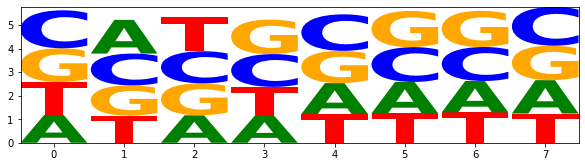

In [18]:
import logomaker
weights = net.conv_mono.weight
weights = weights.squeeze().cpu().detach().numpy()
weights = pd.DataFrame(weights)
weights.index = 'A', 'C', 'G', 'T'
crp_logo = logomaker.Logo(weights.T, shade_below=.5, fade_below=.5)

<AxesSubplot:>

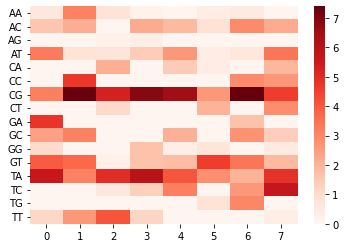

In [20]:
weights = net.conv_di.weight
weights = weights.squeeze().cpu().detach().numpy()
weights = pd.DataFrame(weights)
weights.index = 'AA', 'AC', 'AG', 'AT', 'CA', 'CC', 'CG', 'CT', 'GA', 'GC', 'GG', 'GT', 'TA', 'TC', 'TG', 'TT' 
sns.heatmap(weights, cmap='Reds', vmin=0)

<AxesSubplot:>

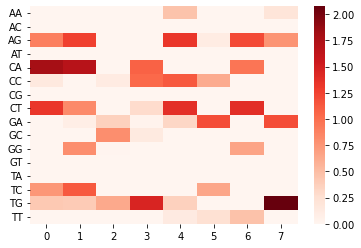

In [21]:
weights = -net.conv_di.weight
weights = weights.squeeze().cpu().detach().numpy()
weights = pd.DataFrame(weights)
weights.index = 'AA', 'AC', 'AG', 'AT', 'CA', 'CC', 'CG', 'CT', 'GA', 'GC', 'GG', 'GT', 'TA', 'TC', 'TG', 'TT' 
sns.heatmap(weights, cmap='Reds', vmin=0)

In [22]:
print(np.exp(net.log_weight_1.squeeze().cpu().detach().numpy()))
print(np.exp(net.log_weight_2.squeeze().cpu().detach().numpy()))

0.0012390771
0.0029834642


[autoreload of multibind.tl.binding_prediction failed: Traceback (most recent call last):
  File "/home/johanna/anaconda3/envs/multibind/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/home/johanna/anaconda3/envs/multibind/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 410, in superreload
    update_generic(old_obj, new_obj)
  File "/home/johanna/anaconda3/envs/multibind/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 347, in update_generic
    update(a, b)
  File "/home/johanna/anaconda3/envs/multibind/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 302, in update_class
    if update_generic(old_obj, new_obj): continue
  File "/home/johanna/anaconda3/envs/multibind/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 347, in update_generic
    update(a, b)
  File "/home/johanna/anaconda3/envs/multibind/lib/python3.6/site-pa

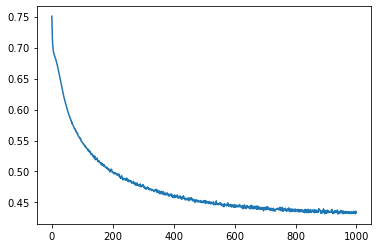

In [23]:
loss_history = np.array(loss_history)
plt.plot(loss_history)

If we look for 'TG' in the kmer_analysis, it is mainly found in the upper half. If we look for 'CG', it is only found in the lower half.

-----

In [5]:
# Mono + Dinuc model, combined via weighted sum
net = mb.tl.NetworkDinuc().to(device)
optimiser = topti.Adam(net.parameters(), lr=0.001)
criterion = tnn.BCELoss()
loss_history = []

In [16]:
loss_history += mb.tl.train_network(net, train_1000_loader, device, optimiser, criterion, num_epochs=100)

Epoch:  1, Loss: 0.417
Epoch:  2, Loss: 0.419
Epoch:  3, Loss: 0.417
Epoch:  4, Loss: 0.417
Epoch:  5, Loss: 0.419
Epoch:  6, Loss: 0.421
Epoch:  7, Loss: 0.416
Epoch:  8, Loss: 0.418
Epoch:  9, Loss: 0.419
Epoch: 10, Loss: 0.418
Epoch: 11, Loss: 0.424
Epoch: 12, Loss: 0.416
Epoch: 13, Loss: 0.416
Epoch: 14, Loss: 0.418
Epoch: 15, Loss: 0.418
Epoch: 16, Loss: 0.419
Epoch: 17, Loss: 0.418
Epoch: 18, Loss: 0.418
Epoch: 19, Loss: 0.420
Epoch: 20, Loss: 0.416
Epoch: 21, Loss: 0.416
Epoch: 22, Loss: 0.419
Epoch: 23, Loss: 0.421
Epoch: 24, Loss: 0.417
Epoch: 25, Loss: 0.417
Epoch: 26, Loss: 0.419
Epoch: 27, Loss: 0.419
Epoch: 28, Loss: 0.418
Epoch: 29, Loss: 0.417
Epoch: 30, Loss: 0.419
Epoch: 31, Loss: 0.417
Epoch: 32, Loss: 0.416
Epoch: 33, Loss: 0.417
Epoch: 34, Loss: 0.419
Epoch: 35, Loss: 0.417
Epoch: 36, Loss: 0.415
Epoch: 37, Loss: 0.416
Epoch: 38, Loss: 0.415
Epoch: 39, Loss: 0.416
Epoch: 40, Loss: 0.417
Epoch: 41, Loss: 0.419
Epoch: 42, Loss: 0.418
Epoch: 43, Loss: 0.415
Epoch: 44, 

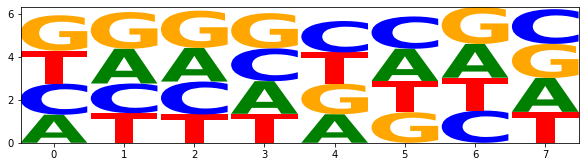

In [17]:
import logomaker
weights = net.conv_mono.weight
weights = weights.squeeze().cpu().detach().numpy()
weights = pd.DataFrame(weights)
weights.index = 'A', 'C', 'G', 'T'
crp_logo = logomaker.Logo(weights.T, shade_below=.5, fade_below=.5)

<AxesSubplot:>

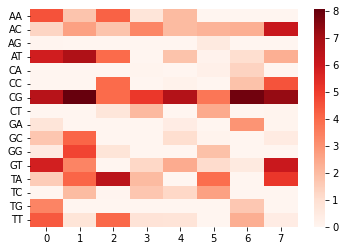

In [18]:
weights = net.conv_di.weight
weights = weights.squeeze().cpu().detach().numpy()
weights = pd.DataFrame(weights)
weights.index = 'AA', 'AC', 'AG', 'AT', 'CA', 'CC', 'CG', 'CT', 'GA', 'GC', 'GG', 'GT', 'TA', 'TC', 'TG', 'TT' 
sns.heatmap(weights, cmap='Reds', vmin=0)

<AxesSubplot:>

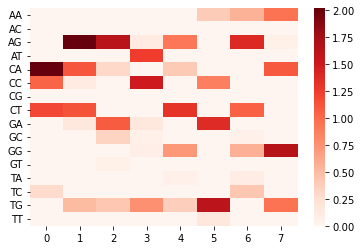

In [19]:
weights = -net.conv_di.weight
weights = weights.squeeze().cpu().detach().numpy()
weights = pd.DataFrame(weights)
weights.index = 'AA', 'AC', 'AG', 'AT', 'CA', 'CC', 'CG', 'CT', 'GA', 'GC', 'GG', 'GT', 'TA', 'TC', 'TG', 'TT' 
sns.heatmap(weights, cmap='Reds', vmin=0)

0.0011126555
0.0028813744


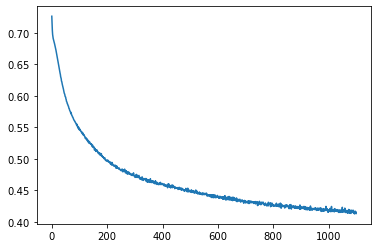

In [20]:
print(np.exp(net.log_weight_1.squeeze().cpu().detach().numpy()))
print(np.exp(net.log_weight_2.squeeze().cpu().detach().numpy()))
loss_history = np.array(loss_history)
plt.plot(loss_history)

---

In [1]:
import itertools
import pandas as pd

data = pd.read_csv('../data/gata1_remap.tsv.gz', sep=',')
data.columns = ['id', 'loc', 'seq', 'target']
misreads = []
for index, seq in enumerate(data['seq']):
    if seq.replace('A', '').replace('C', '').replace('G', '').replace('T', '') is not '':
        misreads.append(index)
data = data.drop(misreads)
data.index = range(len(data))


counts = {''.join(opt): [0, 0] for opt in itertools.product('ACTG', repeat=2)}
for i, seq in enumerate(data['seq']):
    for j in range(len(seq) - 1):
        kmer = seq[j:j+2]
        counts[kmer][data['target'][i]] += 1
counts_df = pd.DataFrame.from_dict(counts, orient='index')
counts_df['ratio'] = counts_df[1]/counts_df[0]
counts_df.sort_values('ratio', ascending=False)

,0,1,ratio
CT,3866568,4820786,1.246787
AG,3870645,4824545,1.246445
TG,3802074,4725015,1.242747
CA,3798485,4718970,1.242330
CC,3378098,3749224,1.109862
GG,3387473,3756510,1.108942
TC,3867034,4049587,1.047207
GA,3871269,4051729,1.046615
AA,5249995,5381105,1.024973
TT,5258193,5384237,1.023971


In [2]:
data

,id,loc,seq,target
0,0,chr1:115630-115830,GGAGCCGGGTCATGAAAAAGGGGATCTTGTGTGTCTGTCCACGATA...,1
1,1,chr1:629839-630039,CATAATCCTTCTAATAGCTATCCTCTTCAACAATATACTCTCCGGA...,1
2,2,chr1:630217-630417,TCTACCGTACAACCCTAACATAACCATTCTTAATTTAACTATTTAT...,1
3,3,chr1:631766-631966,CAACACCTATTCTGATTTTTCGGTCACCCTGAAGTTTATATTCTCA...,1
4,4,chr1:632943-633143,CCGTCTGAACTATCCTGCCCGCCATCATCCTAGTCCTTATCGCCCT...,1
...,...,...,...,...
647749,647773,chrY:56845083-56845283_rand,GGGCTACTGTGATTTGGGTTAAATGCTTGCAGTTGTAATCACGCGT...,0
647750,647774,chrY:56846140-56846340_rand,CGATTGTAGTTTCGAATTTGTGACCACTCGGTTCGTGCGGATCTCA...,0
647751,647775,chrY:56849467-56849667_rand,GATGATTTCCATATAAAATGAAGTACATGCTCTTGGGAAGTTTACC...,0
647752,647776,chrY:56850584-56850784_rand,TTTATTTCTAACGTAAAGGCTTCCGGGCGTTACTAGTCTATTAGTG...,0


In [ ]:
# Mono + Dinuc model, combined via weighted sum
net = mb.tl.NetworkDinuc().to(device)
optimiser = topti.Adam(net.parameters(), lr=0.001)
criterion = tnn.BCELoss()
loss_history = []